In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

In [2]:
sb.set_style('darkgrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# Env

In [14]:
from Env.env_torch import BSMarketTorch

env_config = \
{'cost': 0.02,
 'dividend': 0.0,
 'drift': 1.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'random_drift': False,
 'random_vol': False,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}

env = BSMarketTorch(**env_config)

env 'BSMarket was created!


# Reward

In [15]:
def step_reward(env, model):
    obs = env.get_obs()
    action = model(obs)
    obs, reward, done, info = env.step(action)
    return obs, env.raw_reward, done, info

def episode_reward(env, model):
    obs = env.reset()
    done, info = False, {}
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)

    return obs, env.raw_reward, done, info

# Trainer

In [16]:
from tqdm import tqdm
from Env.rewards_torch import mean_variance_reward, cvar_reward, pnl_entropic_reward

def train(env: BSMarketTorch, model: nn.Module, epochs:int = 100, reward_name='episode', loss_name='mean var', **kwargs):
    env.reset()
    losses = []
    progress = tqdm(range(epochs))
    optimizer = th.optim.Adam(model.parameters())
    done = False
    for epoch in progress:
        if reward_name == 'step':
            obs, raw_reward, done, info = step_reward(env, model)
        else:
            obs, raw_reward, done, info = episode_reward(env, model)

        if loss_name=='mean var':
            loss = -mean_variance_reward(raw_reward, **kwargs.get('loss_kwargs', {}))
        elif loss_name=='cvar':
            loss = -cvar_reward(raw_reward, **kwargs.get('loss_kwargs', {}))
        elif loss_name=='entropy':
            loss = -pnl_entropic_reward(raw_reward, **kwargs.get('loss_kwargs', {}))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if done:
            obs = env.reset()

    return losses

# model

In [17]:
from Utils.tensors import create_module, clamp, set_seed
from Utils.prices_torch import european_call_delta


class FFN(nn.Module):
    def __init__(self, in_features, net_arch, activation_fn=nn.ReLU, net_kwargs=None):
        super(FFN, self).__init__()
        mlp = create_module(in_features, 1, net_arch, activation_fn, squash_output=True, net_kwargs=net_kwargs)
        self.mlp = nn.Sequential(*mlp)
        self.flatten = nn.Flatten(0)

    def forward(self, obs):
        action = self.mlp(obs['obs'])
        action = self.flatten(action)
        return (action + 1.0) * 0.5


class NTB(nn.Module):
    def __init__(self, in_features, net_arch, activation_fn=nn.ReLU, net_kwargs=None):
        super(NTB, self).__init__()
        mlp = create_module(in_features, 2, net_arch, activation_fn, squash_output=False, net_kwargs=net_kwargs)
        self.mlp = nn.Sequential(*mlp)
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten(0)

    def forward(self, obs):
        prev_hedge = obs['prev_hedge']
        action = self.mlp(obs['obs'])

        moneyness, expiry, volatility, drift = [obs['obs'][..., i] for i in range(4)]
        delta = european_call_delta(moneyness, expiry, volatility, drift).to(action)

        scaler = 2.0 - 1e-5
        delta_unscaled = (delta * scaler - scaler / 2).atanh()

        if th.isinf(delta_unscaled).any():
            raise ValueError('inf value passed!')

        lb = self.tanh(delta_unscaled - F.leaky_relu(action[..., 0]))   # [-inf, inf] - [0, inf] = [ -inf, inf]
        ub = self.tanh(delta_unscaled + F.leaky_relu(action[..., 1]))   # [-inf, inf] + [0, inf] = [-inf, inf]

        prev_hedge_unscaled = 2.0 * prev_hedge - 1.0
        action = clamp(prev_hedge_unscaled, lb, ub)

        action = self.flatten(action)

        return (action + 1.0) * 0.5

# main

In [18]:
from pprint import pp
set_seed()

env = BSMarketTorch(**env_config)
pp(env_config)

env 'BSMarket was created!
{'cost': 0.02,
 'dividend': 0.0,
 'drift': 1.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'random_drift': False,
 'random_vol': False,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [19]:
bn = (nn.BatchNorm1d, 'bn')

model_config = {'in_features': 4,
                'net_arch': [32, bn, 32, bn, 32, bn, 32],
                'activation_fn': nn.ReLU,
                'net_kwargs': {'bn_kwargs':{'num_features': 32}}}

set_seed()
ffn = FFN(**model_config)
set_seed()
ntb = NTB(**model_config)

print(ffn)
print(ntb)

FFN(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=1, bias=True)
    (12): Tanh()
  )
  (flatten): Flatten(start_dim=0, end_dim=-1)
)
NTB(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5):

### before train

In [20]:
with th.no_grad():
    ffn_pnl = episode_reward(env, ffn)[1]
    ntb_pnl = episode_reward(env, ntb)[1]

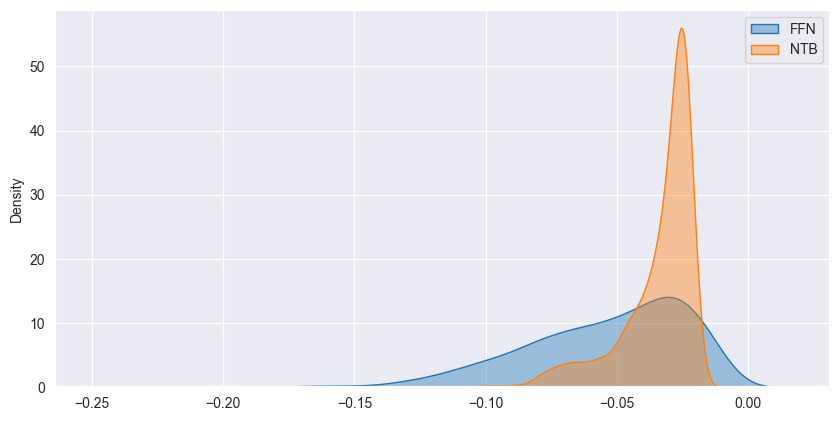

mean
FFN: -0.0547, 0.0320
NTB: -0.0547, 0.0320
cvar
FFN: -0.1345
NTB: -0.0765


In [21]:
sb_kwargs = {'shade': True,
              'alpha': 0.4,
             'clip': (-0.06, -0.01)
             }

sb.kdeplot(ffn_pnl, **sb_kwargs, label='FFN')
sb.kdeplot(ntb_pnl, **sb_kwargs, label='NTB')
plt.legend()
plt.show()

print('mean')
print(f'FFN: {ffn_pnl.mean():.4f}, {ffn_pnl.std():.4f}')
print(f'NTB: {ffn_pnl.mean():.4f}, {ffn_pnl.std():.4f}')
print('cvar')
print(f'FFN: {cvar_reward(ffn_pnl):.4f}')
print(f'NTB: {cvar_reward(ntb_pnl):.4f}')

### after train

In [22]:
train_config = {'epochs': 100,
                'reward_name': 'episode',
                'loss_name': 'entropy'
                }

ffn_loss = train(env, ffn, **train_config)
ntb_loss = train(env, ntb, **train_config)

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


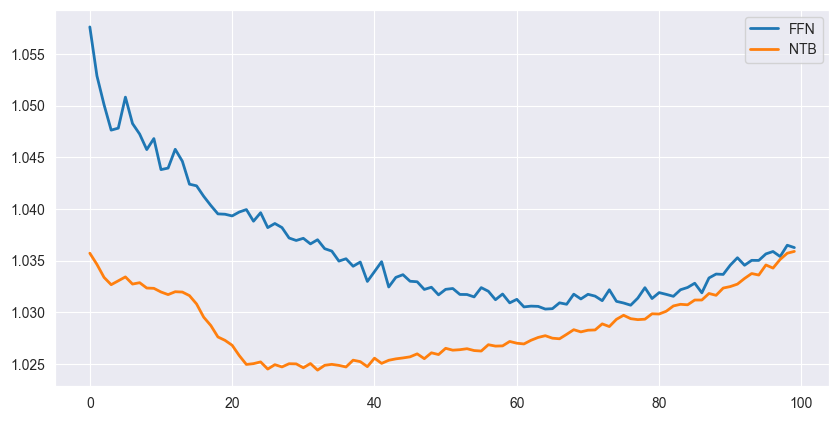

In [23]:
from Utils.tensors import to_numpy

plt.plot(ffn_loss, label='FFN')
plt.plot(ntb_loss, label='NTB')
plt.legend()
plt.show()

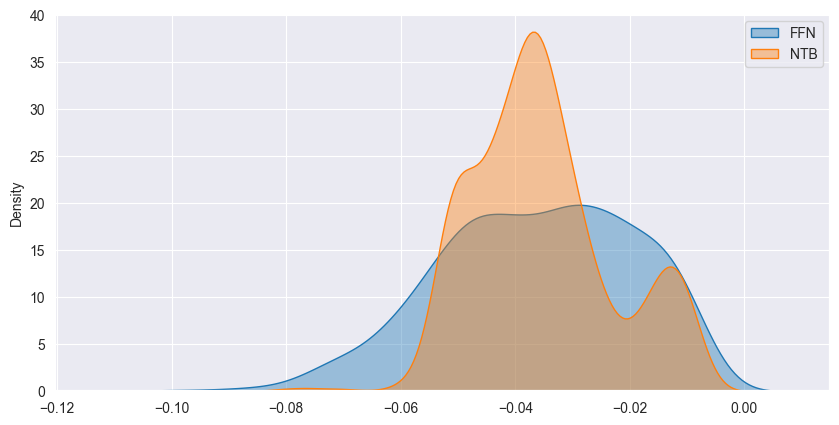

mean
FFN: -0.0361, 0.0171
NTB: -0.0361, 0.0171
cvar
FFN: -0.0735
NTB: -0.0559


In [24]:
with th.no_grad():
    ffn_pnl = episode_reward(env, ffn)[1]
    ntb_pnl = episode_reward(env, ntb)[1]

sb_kwargs = {'shade': True,
             'alpha': 0.4,
             'clip': (-0.06, -0.01)
             }

sb.kdeplot(ffn_pnl, **sb_kwargs, label='FFN')
sb.kdeplot(ntb_pnl, **sb_kwargs, label='NTB')
plt.legend()
plt.show()

print('mean')
print(f'FFN: {ffn_pnl.mean():.4f}, {ffn_pnl.std():.4f}')
print(f'NTB: {ffn_pnl.mean():.4f}, {ffn_pnl.std():.4f}')
print('cvar')
print(f'FFN: {cvar_reward(ffn_pnl):.4f}')
print(f'NTB: {cvar_reward(ntb_pnl):.4f}')

In [ ]:
import torch as th
from Utils.tensors import create_module

q1 = nn.Sequential(*create_module(6, 1, [], activation_fn=None))
q2 = nn.Sequential(*create_module(6, 1, [2], activation_fn=None))
